# 1. Setup

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
import dalex as dx


from sklearn.model_selection import train_test_split, StratifiedKFold
import shap
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
import lightgbm as lgb
import xgboost as xgb
import shap
import lime
import lime.lime_tabular
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance
from alibi.explainers import Counterfactual
from sklearn.inspection import PartialDependenceDisplay

import PyALE



from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

sns.set_theme(style="whitegrid")

# 2. Load Dataset

In [ ]:

df_train = pd.read_csv('./dataset.csv')
X_train_full = df_train.iloc[:,1:].drop('target_variable', axis=1)

y_train_full = df_train['target_variable']

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(
    X_train_full,
    y_train_full,
    test_size=0.2,
    random_state=1234,
    stratify=y_train_full
)

# 3. Model

## LightGBM

### Métodos locales

In [12]:
'''
# Crear modelo base con LightGBM
lgbm = LGBMClassifier(
    objective='binary',
    random_state=1234,
    verbosity=-1  # Silenciar logs
)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0],
    'min_child_samples': [10, 20]
}

search = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_grid,
    n_iter=5,        # ⬅️ Solo 5 combinaciones
    scoring='f1',
    cv=3,            # ⬅️ Solo 3 folds (no 5)
    random_state=1234,
    n_jobs=-1,
    verbose=1
)

# Entrenar
search.fit(X_train, y_train)

# Mejor modelo
best_lgbm = search.best_estimator_'''

"\n# Crear modelo base con LightGBM\nlgbm = LGBMClassifier(\n    objective='binary',\n    random_state=1234,\n    verbosity=-1  # Silenciar logs\n)\n\nparam_grid = {\n    'n_estimators': [100, 200],\n    'max_depth': [4, 6, 8],\n    'learning_rate': [0.05, 0.1],\n    'subsample': [0.8, 1.0],\n    'min_child_samples': [10, 20]\n}\n\nsearch = RandomizedSearchCV(\n    estimator=lgbm,\n    param_distributions=param_grid,\n    n_iter=5,        # ⬅️ Solo 5 combinaciones\n    scoring='f1',\n    cv=3,            # ⬅️ Solo 3 folds (no 5)\n    random_state=1234,\n    n_jobs=-1,\n    verbose=1\n)\n\n# Entrenar\nsearch.fit(X_train, y_train)\n\n# Mejor modelo\nbest_lgbm = search.best_estimator_"

In [13]:
'''search.best_estimator_'''

'search.best_estimator_'

In [14]:
best_lgbm = LGBMClassifier(
    boosting_type =	'gbdt',
    num_leaves = 31,
    max_depth = 8,
    learning_rate =	0.1,
    n_estimators = 200,
    subsample_for_bin = 200000,
    objective = 'binary',
    class_weight = None,
    min_split_gain = 0.0,
    min_child_weight = 	0.001,
    min_child_samples =	10,
    subsample =	1.0,
    subsample_freq = 0,
    colsample_bytree = 1.0,
    reg_alpha = 0.0,
    reg_lambda = 0.0,
    random_state = 1234,
    n_jobs = None,
    importance_type = 'split',
    verbosity = -1
)

              precision    recall  f1-score   support

           0       0.77      0.78      0.77      3802
           1       0.75      0.73      0.74      3378

    accuracy                           0.76      7180
   macro avg       0.76      0.76      0.76      7180
weighted avg       0.76      0.76      0.76      7180



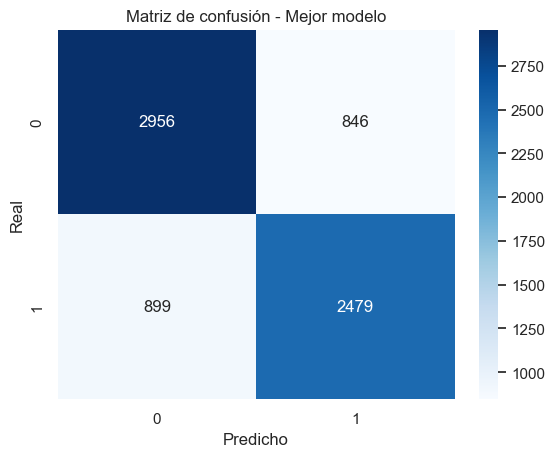

In [ ]:

best_lgbm.fit(X_train, y_train)


preds = best_lgbm.predict(X_test)



# Predecir con el mejor modelo
preds_best_lgbm = best_lgbm.predict(X_test)


print(classification_report(y_test, preds_best_lgbm))


cm_best = confusion_matrix(y_test, preds_best_lgbm)
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de confusión - Mejor modelo')
plt.ylabel('Real')
plt.xlabel('Predicho')
plt.show()

#### Sharp

c:\Users\crost\Documents\GitHub\Datathon-2025\.venv\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


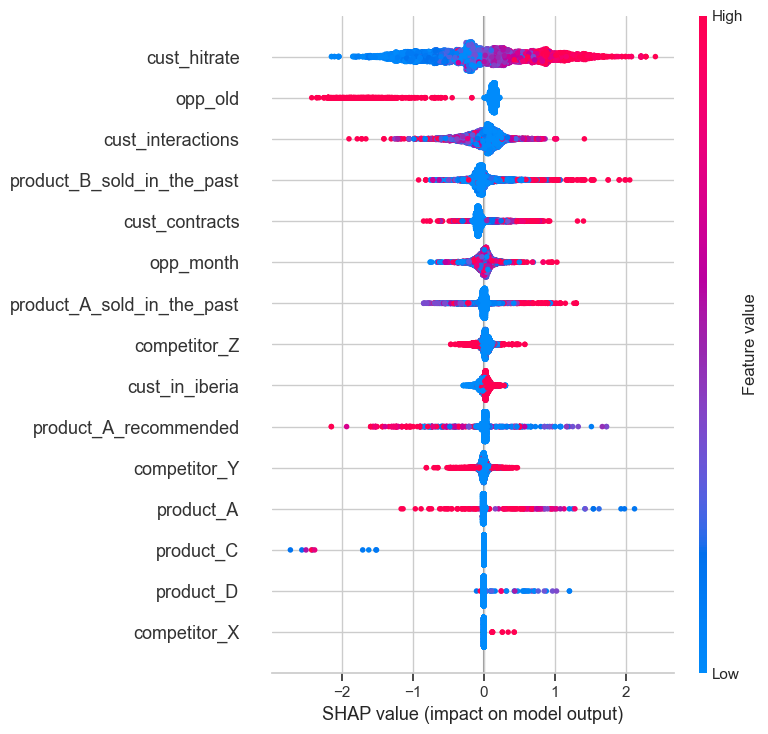

In [ ]:
import shap


explainer = shap.TreeExplainer(best_lgbm)

feature_names = X_test.columns.tolist()


shap_values = explainer.shap_values(X_test)

# si es clasificación binaria, LightGBM también puede devolver una lista
if isinstance(shap_values, list):
    shap_values = shap_values[1]  


shap.summary_plot(shap_values, X_test, feature_names=feature_names)

#### Lime

In [ ]:
import lime
import lime.lime_tabular
from lightgbm import LGBMClassifier


explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    X_train.values,          
    feature_names=feature_names,      
    class_names=['Lost', 'Won'],     
    mode='classification'
)

# Elegir una instancia específica para explicar, en este caso la primera
i = 0
exp = explainer_lime.explain_instance(
    X_test.iloc[i].values,      
    best_lgbm.predict_proba,    
    num_features=X_test.shape[1]     
)


exp.save_to_file('lime_explanation.html') 


c:\Users\crost\Documents\GitHub\Datathon-2025\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


### Métodos globales

PyALE._ALE_generic:INFO: Continuous feature detected.


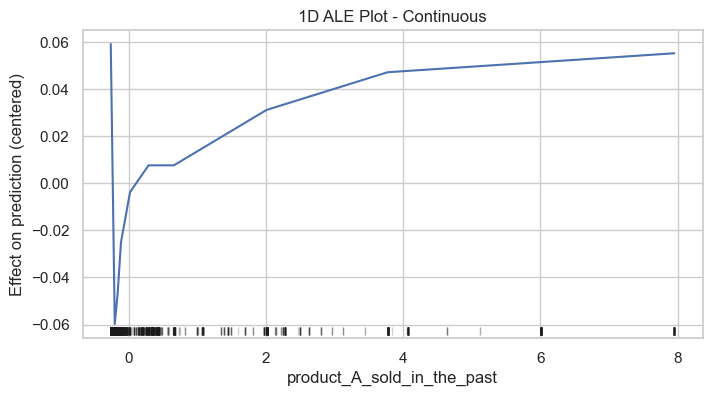

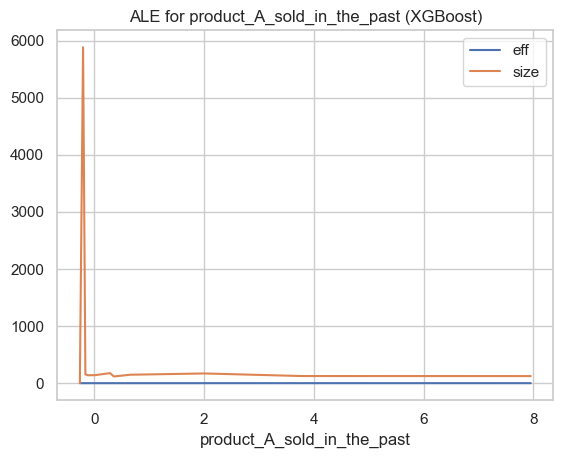

PyALE._ALE_generic:INFO: Continuous feature detected.


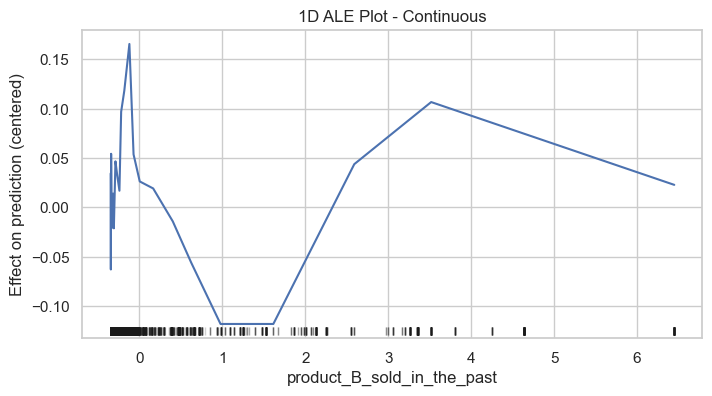

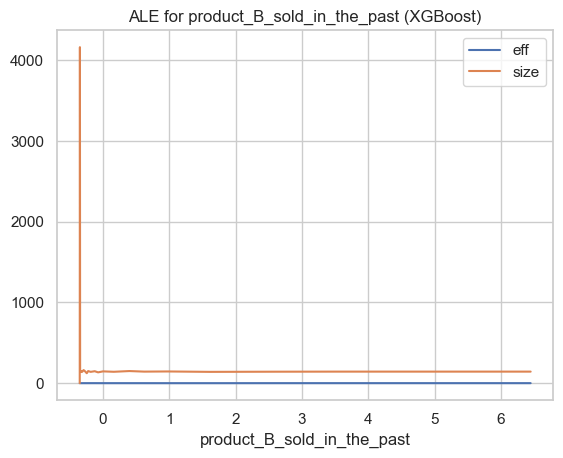

PyALE._ALE_generic:INFO: Continuous feature detected.


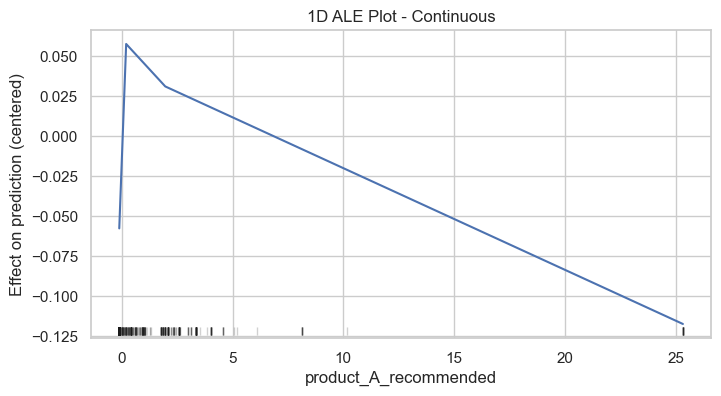

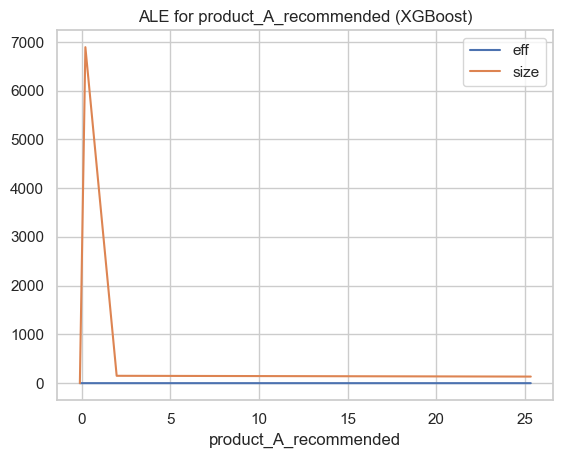

PyALE._ALE_generic:INFO: Continuous feature detected.


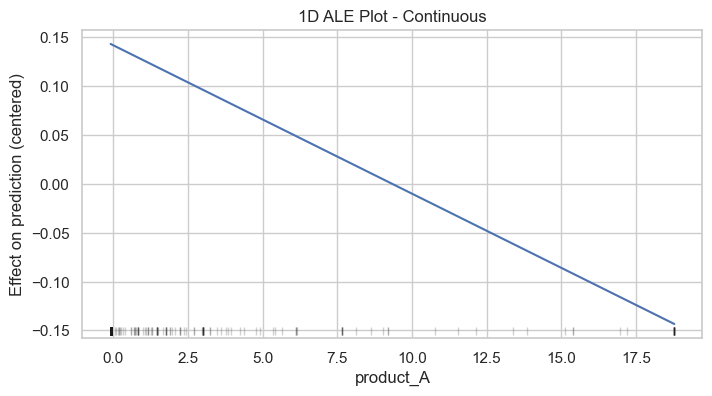

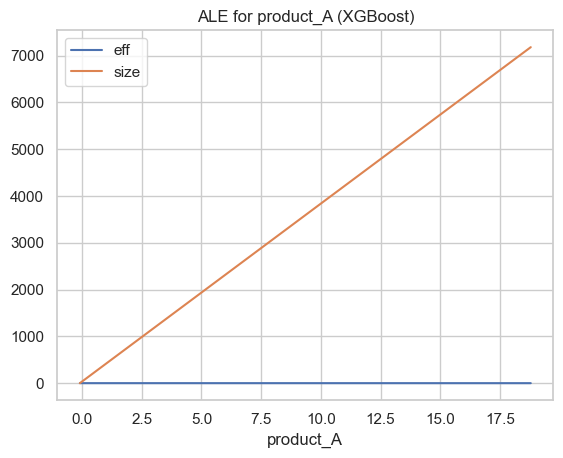

PyALE._ALE_generic:INFO: Discrete feature detected.


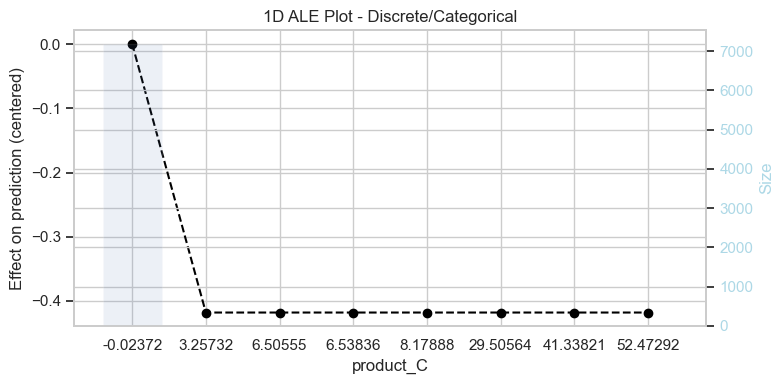

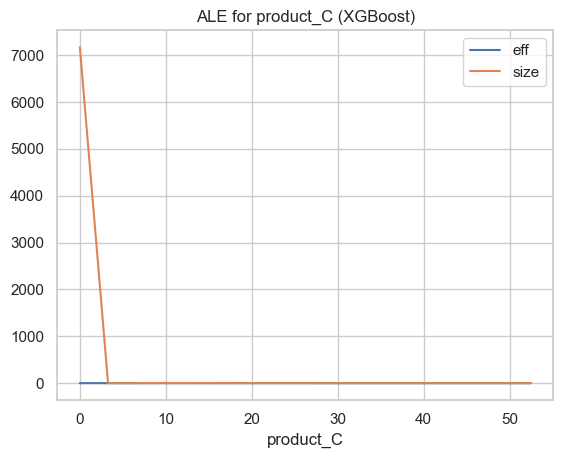

PyALE._ALE_generic:INFO: Continuous feature detected.


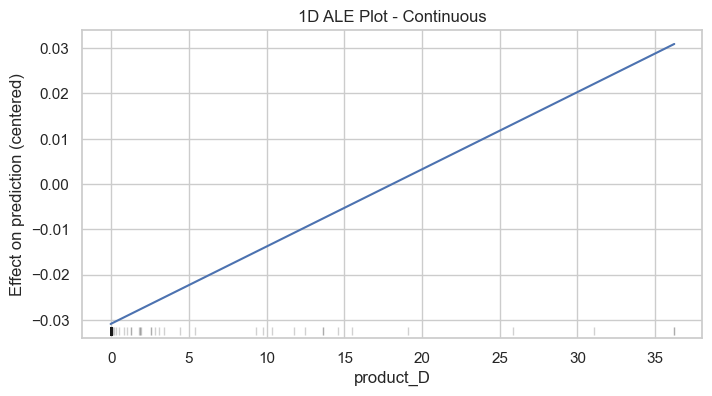

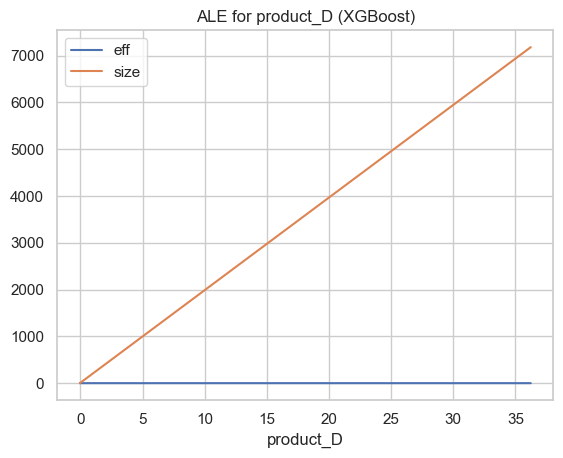

PyALE._ALE_generic:INFO: Continuous feature detected.


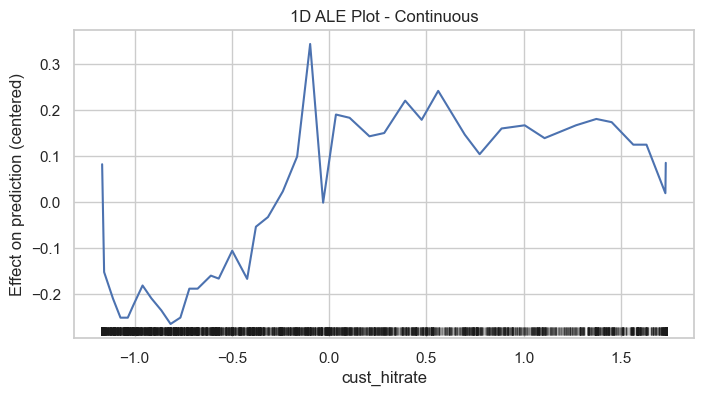

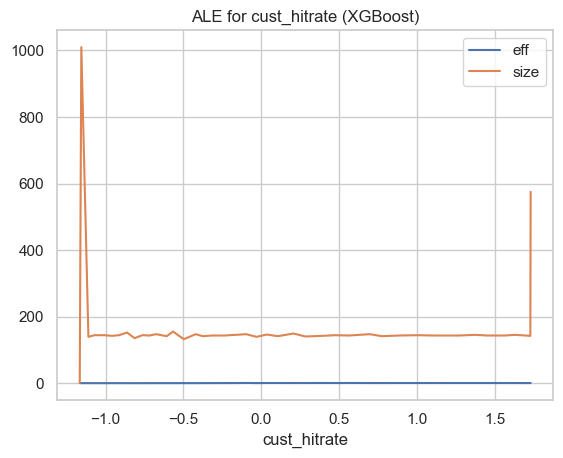

PyALE._ALE_generic:INFO: Continuous feature detected.


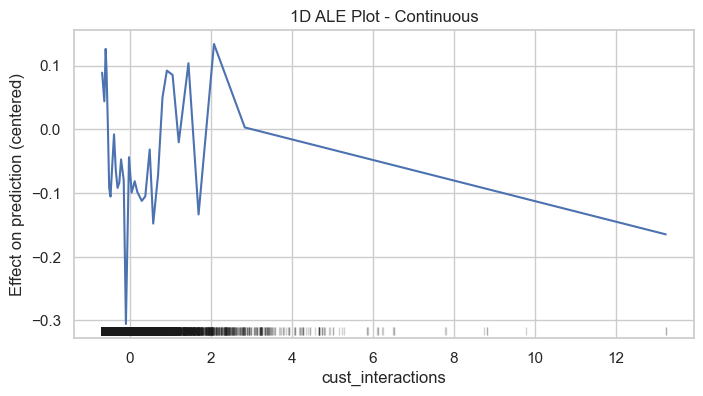

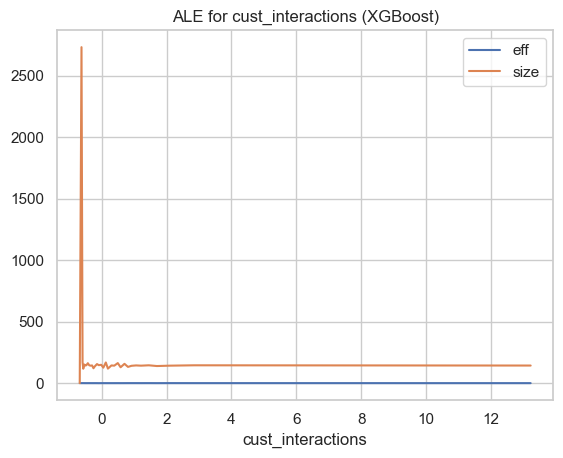

PyALE._ALE_generic:INFO: Continuous feature detected.


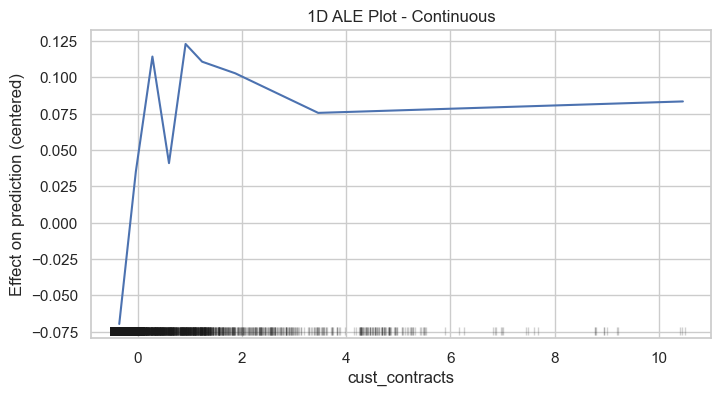

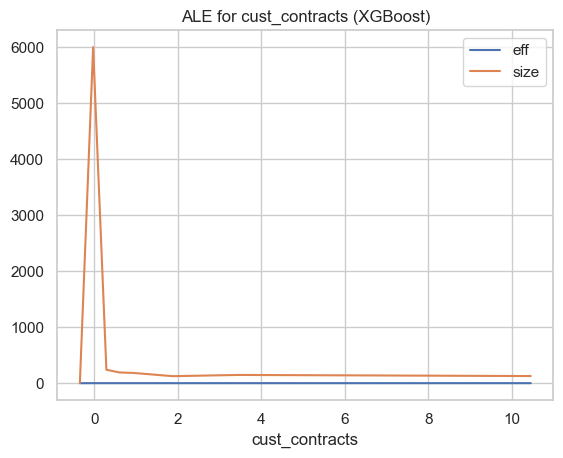

PyALE._ALE_generic:INFO: Discrete feature detected.


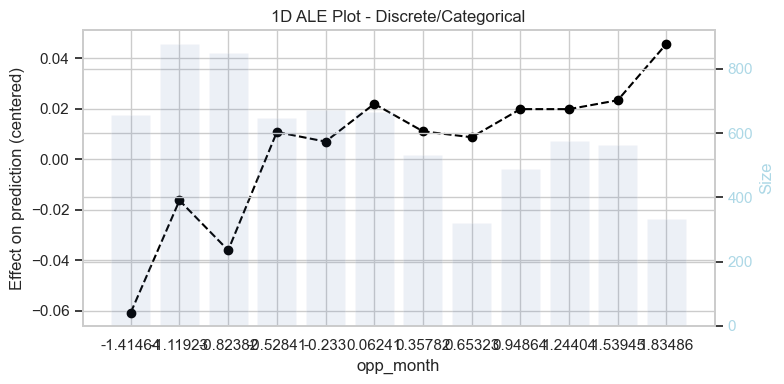

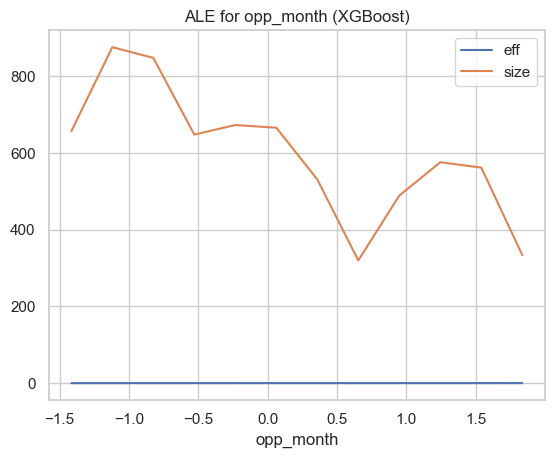

PyALE._ALE_generic:INFO: Discrete feature detected.


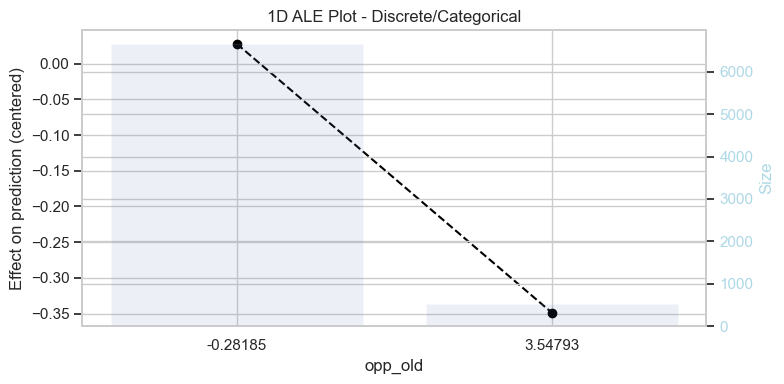

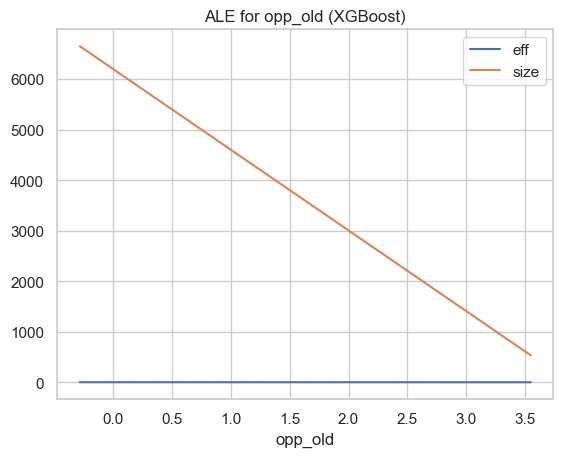

In [ ]:
# Lista de variables numéricas
numeric_features = [
    'product_A_sold_in_the_past',
    'product_B_sold_in_the_past',
    'product_A_recommended',
    'product_A',
    'product_C',
    'product_D',
    'cust_hitrate',  
    'cust_interactions', 
    'cust_contracts', 
    'opp_month', 
    'opp_old'  
]


# Generar ALE para cada variable
for feature in numeric_features:
    try:
        ale_eff = PyALE.ale(
            X=X_test,
            model=best_lgbm,
            feature=[feature],
            grid_size=50,
            include_CI=False
        )
        ale_eff.plot()
        plt.title(f"ALE for {feature} (XGBoost)")
        plt.show()
    except Exception as e:
        print(f"Error generando ALE para {feature}: {e}")